# Factor Analysis

Factor analysis assumes that the observed variables are caused by a smaller number of unobserved (latent) factors and tries to explain why variables are correlated.


# Graphical Summary

![Fig](./graphical_summary/slides/Slide30.png)

# Key Formula

The fundamental factor analysis model:

$$
\mathbf{X} = \mathbf{FL} + \mathbf{E}
$$

where:
- $\mathbf{X}$ is a $N \times p$ matrix of observed variables ($N$ is the number of samples, $p$ is the number of variables)
- $\mathbf{F}$ is a $N \times k$ matrix of **factor scores** (factor values for each observation)
- $\mathbf{L}$ is a $k \times p$ matrix of **loading matrix** (how strongly each variable relates to each factor)
- $\mathbf{E}$ is a $N \times p$ matrix of **unique errors** (noise)
- $k \leq p$, $k$ is the number of latent factors

# Technical Details


## Indeterminacy of Matrix Decomposition

For any invertible matrix $\mathbf{T}$ (sometimes called **rotation matrix**):
$$
\mathbf{X} = \mathbf{FL} + \mathbf{E} = (\mathbf{FT})(\mathbf{T}^{-1}\mathbf{L}) + \mathbf{E}
$$

**Result:** Infinitely many $(\mathbf{F}, \mathbf{L})$ pairs fit the data equally well (i.e., same $\mathbf{E}$)! Therefore the key to the factor analysis is the constraints on $\mathbf{L}$ and/or $\mathbf{F}$!


## Common Constraints

The estimated factors and loadings must often satisfy domain-specific constraints to ensure they are biologically or statistically meaningful. The specific constraints depend on the application context.

### Constraints in Admixture Analysis ([Example 1](#example-1-admixture-analysis-using-admixture))

In the admixture analysis, we consider the problem of $N$ individuals that comes from $k$ ancestries, and $p$ is the number of genetic variants.

$\mathbf{F}$($N \times k$) is the proportion of each ancestry for each individual; $\mathbf{L}$($k \times p$) is allele frequency of each variant in each ancestry.

- **Constraint on $\mathbf{F}$**: 
  - $\forall i \in \{1,..., N\},   \sum_j\mathbf{F}_{ij}=1$: only the $k$ ancestries are considered
  - $\forall i \in \{1,..., N\}, j \in \{1,..., p\}, 0 \leq\mathbf{F}_{ij} \leq 1$: all frequencies are between 0 and 1. 

### Constraints in Non-negative Matrix Factorization

Non-negative matrix factorization (NMF or NNMF), also non-negative matrix approximation is a group of algorithms in multivariate analysis and linear algebra where a matrix $\mathbf{X}$ is factorized into (usually) two matrices $\mathbf{F}$ and $\mathbf{L}$, with the property that all three matrices have no negative elements. This non-negativity makes the resulting matrices easier to inspect. 

### Constraints in Principal Component Analysis

PCA can also be considered as a factor analysis, which we will introduce more in [Principal Component Analysis](https://statfungen.github.io/statgen-prerequisites/PCA.html). It is closely related to the singular value decomposition of a matrix. 

## Proportion of Variance Explained

The total variance in $\mathbf{X}$ can be decomposed into explained and unexplained components:

$$
\text{Var}(\mathbf{X}) = \text{Var}(\mathbf{FL}) + \text{Var}(\mathbf{E})
$$

**A good factor analysis should:**

1. **Explain most of the variance**: This means the error matrix $\mathbf{E}$ is small relative to the signal $\mathbf{LF}$
2. **Easy to interpret the factors**: Reveal underlying biological pathways or mechanisms.
3. **Use fewer factors than variables**: $k \ll p$
   - Achieve dimensionality reduction (fewer latent causes than observed effects)
   - Example: 100 genetic markers → 2 ancestral populations

# Related Topics

- [Principal Component Analysis](https://statfungen.github.io/statgen-prerequisites/PCA.html)
- [Proportion of Variance Explained](https://statfungen.github.io/statgen-prerequisites/proportion_of_variance_explained.html)
- [Genetic Relationship Matrix](https://statfungen.github.io/statgen-prerequisites/genetic_relationship_matrix.html)
- [Bayesian Mixture Model](https://statfungen.github.io/statgen-prerequisites/Bayesian_mixture_model.html)

# Example

## Example 1: Admixture Analysis using ADMIXTURE

Human populations have genetic diversity shaped by evolutionary history and migration patterns. Different populations often carry different genetic variants at various frequencies due to their geographic origin and ancestry. A key question in population genetics is: **given an individual's genotypes at many genetic markers, can we infer what proportion of their ancestry comes from different ancestral populations?** This is particularly important in admixed populations, where individuals have ancestry from multiple sources. Understanding ancestry composition helps us understand human evolution, control for confounding in medical studies, and interpret genetic variation in diverse populations.

### Generate Data 
Like we did in other notebooks, let's first simulate the data given the generative model of truth, i.e., to mimic the way that **nature creates admixed individuals**. 

Imagine we have two ancestral populations. In reality, different populations have evolved in different geographic regions, and thus they carry different genetic variants at different frequencies. Let's start with assuming that in our two ancestral populations, the frequencies of genetic markers are very different from each other. We will represent these population-specific marker frequencies in a matrix called $\mathbf{L}$ (the allele frequency matrix).

Next, we create individuals with mixed ancestry. Some individuals might come purely from one ancestral population, while others might be mixtures of the two populations. We represent each individual's ancestry proportions in a matrix called $\mathbf{F}$ (the ancestry proportion matrix). For example, an individual might be 60% from Population 1 and 40% from Population 2.

Finally, given an individual's ancestry composition ($\mathbf{F}$) and the population marker frequencies ($\mathbf{L}$), we can generate that individual's genotypes. By combining the ancestry proportions with the population frequencies, we can simulate realistic genetic data.

#### Step 1: Define ancestral populations ($\mathbf{L}$)

We start by assuming that two ancestral populations have very distinct marker frequencies. We represent these population-specific allele frequencies in matrix $\mathbf{L}$, where $\mathbf{L}[j, k]$ = frequency of marker $j$ in population $k$.

The key insight is that the two populations differ substantially at these markers, making them genetically distinguishable.

In [149]:
rm(list=ls())
set.seed(74)

I <- 50  # Number of individuals
J <- 100  # Number of markers (SNPs)
K <- 2   # Number of ancestral populations

# Create L matrix with very distinct population frequencies
L_true <- matrix(0, nrow = J, ncol = K)

# Population 1: generally higher frequencies in the first 50 SNPS, lower frequencies in the last 50
L_true[1:50, 1] <- runif(50, 0.7, 0.95)
L_true[51:100, 1] <- runif(50, 0.05, 0.3)

# Population 2: inverse pattern
L_true[1:50, 2] <- runif(50, 0.05, 0.3)
L_true[51:100, 2] <- runif(50, 0.8, 0.95)

# Add row and column names
rownames(L_true) <- paste0("SNP", 1:J)
colnames(L_true) <- paste0("Pop", 1:K)

print("L matrix (first 10 SNPs):")
head(L_true, 10)

[1] "L matrix (first 10 SNPs):"


,Pop1,Pop2
SNP1,0.8761540,0.06645544
SNP2,0.8200011,0.07491498
SNP3,0.7490044,0.07030163
SNP4,0.9342427,0.05800303
SNP5,0.9174576,0.10867092
SNP6,0.7535080,0.14010499
SNP7,0.7060213,0.15881236
SNP8,0.9136990,0.24469917
SNP9,0.8756788,0.24406956
SNP10,0.9394954,0.18406457


#### Step 2: Create individuals with different ancestry proportions ($\mathbf{F}$ matrix)

Now we create fifty individuals with different ancestry mixtures:
- **Individuals 1-15**: Pure ancestry from Population 1
- **Individuals 16-30**: Pure ancestry from Population 2
- **Individuals 31-40**: Mixed ancestry (80% Population 1, 20% Population 2)
- **Individuals 41-50**: Mixed ancestry (30% Population 1, 70% Population 2)

We represent each individual's ancestry proportions in matrix $\mathbf{F}$, where $\mathbf{F}[k, i]$ = proportion of individual $i$'s genome from population $k$. Each column of $\mathbf{F}$ must sum to 1, representing 100% ancestry.

In [150]:
F_true <- matrix(0, nrow = K, ncol = I)

# Individuals 1-15: Pure Pop1
F_true[1, 1:15] <- 1.0
F_true[2, 1:15] <- 0.0

# Individuals 16-30: Pure Pop2
F_true[1, 16:30] <- 0.0
F_true[2, 16:30] <- 1.0

# Individuals 31-40: Pop1-Pop2 admixture (80-20)
F_true[1, 31:40] <- 0.8
F_true[2, 31:40] <- 0.2

# Individuals 41-50: Pop1-Pop2 admixture (30-70)
F_true[1, 41:50] <- 0.3
F_true[2, 41:50] <- 0.7

# Add row and column names
rownames(F_true) <- paste0("Pop", 1:K)
colnames(F_true) <- paste0("Ind", 1:I)

#### Step 3: Generate genotypes based on ancestry ($\mathbf{X}$ matrix)

The crucial insight is that **an individual's genotype depends on their ancestry**. Given:
- An individual's ancestry proportions (row of $\mathbf{F}$)
- The allele frequencies in each population (columns of $\mathbf{L}$)

We can calculate the expected allele frequency for that individual at each marker as a weighted average:

$$p_{ij} = \sum_{k=1}^{K} q_{ik} \times f_{kj}$$

Then we sample the individual's genotype from a binomial distribution with this expected frequency. The result is matrix $\mathbf{X}$ (the genotype matrix), where $\mathbf{X}[i, j]$ = genotype (0, 1, or 2 copies) of individual $i$ at marker $j$.

In [151]:
X_raw <- matrix(0, nrow = J, ncol = I)

for (i in 1:I) {
  for (j in 1:J) {
    # Expected frequency = weighted average of population frequencies
    p_ij <- sum(L_true[j, ] * F_true[, i])
    
    # Sample genotype (0, 1, or 2 copies)
    X_raw[j,i] <- rbinom(1, size = 2, prob = p_ij)
  }
}

# Add row and column names
rownames(X_raw) <- paste0("SNP", 1:J)
colnames(X_raw) <- paste0("Ind", 1:I)

print("A few rows for the generated raw genotype matrix X_raw:")
head(X_raw,3)

[1] "A few rows for the generated raw genotype matrix X_raw:"


,Ind1,Ind2,Ind3,Ind4,Ind5,Ind6,Ind7,Ind8,Ind9,Ind10,⋯,Ind41,Ind42,Ind43,Ind44,Ind45,Ind46,Ind47,Ind48,Ind49,Ind50
SNP1,1,2,2,1,2,2,2,2,2,2,⋯,1,1,1,1,0,1,1,1,1,1
SNP2,2,2,2,2,2,2,0,2,2,2,⋯,1,1,0,1,0,0,1,1,0,0
SNP3,0,2,2,1,2,2,1,2,2,2,⋯,1,1,1,1,0,0,1,0,2,1


### Solve for $\mathbf{L}$ and $\mathbf{F}$ using ADMIXTURE

Now comes the interesting part! We have the genotype matrix $\mathbf{X}$, but in reality, we don't know the true $\mathbf{L}$ and $\mathbf{F}$ matrices. We need to **estimate** them from the data using the ADMIXTURE algorithm.

#### The ADMIXTURE Algorithm

The ADMIXTURE algorithm is based on maximum likelihood estimation. It finds the $\mathbf{L}$ and $\mathbf{F}$ matrices that maximize the probability of observing the genotype data $\mathbf{X}$.

**Constraints:**
- $0 \leq L_{jk} \leq 1$ (allele frequencies must be valid probabilities)
- $F_{ki} \geq 0$ and $\sum_{k=1}^{K} F_{ki} = 1$ (ancestry proportions must sum to 1)

**Block Relaxation Strategy:**
1. Fix $\mathbf{F}$, update $\mathbf{L}$ to maximize likelihood
2. Fix $\mathbf{L}$, update $\mathbf{F}$ to maximize likelihood
3. Repeat until convergence


In [152]:
# Log-likelihood function
compute_loglik <- function(X, L, F) {
  I <- ncol(X)
  J <- nrow(X)
  
  loglik <- 0
  for (i in 1:I) {
    for (j in 1:J) {
      p_ij <- sum(F[, i] * L[j, ])
      p_ij <- pmax(0.001, pmin(0.999, p_ij))
      loglik <- loglik + X[j, i] * log(p_ij) + (2 - X[j, i]) * log(1 - p_ij)
    }
  }
  return(loglik)
}

# EM Algorithm for ADMIXTURE, based on Alexander et al. 2009
# The key is the E-step computes expected counts of alleles FROM EACH POPULATION
admixture_em <- function(X, K, max_iter = 100, tol = 1e-4) {
  I <- ncol(X)
  J <- nrow(X)
  
  # Initialize L and F
  set.seed(123)
  L <- matrix(runif(J * K, 0.3, 0.7), nrow = J, ncol = K)
  F <- matrix(runif(K * I), nrow = K, ncol = I)
  for (i in 1:I) {
    F[, i] <- F[, i] / sum(F[, i])
  }
  
  loglik_history <- numeric(max_iter)
  
  cat("Running ADMIXTURE (EM algorithm) (only first five iterations)...\n")
  cat(sprintf("Iteration | Log-likelihood | Change\n"))
  cat(sprintf("-----------------------------------------\n"))
  
  for (iter in 1:max_iter) {
    # M-step: Update L (allele frequencies)
    for (j in 1:J) {
      for (k in 1:K) {
        numerator <- 0    # E[alleles from pop k with reference variant at SNP j]
        denominator <- 0  # E[total alleles from pop k at SNP j]
        
        for (i in 1:I) {
          # Current predicted allele frequency for this individual
          p_ij <- sum(F[, i] * L[j, ])
          p_ij <- pmax(0.001, pmin(0.999, p_ij))

          weight <- F[k, i] * L[j, k] / p_ij
          
          # Expected number of alleles from pop k (out of X[j,i] observed)
          numerator <- numerator + X[j, i] * weight
          denominator <- denominator + 2 * weight
        }
        
        if (denominator > 0) {
          L[j, k] <- numerator / denominator
        }
        L[j, k] <- pmax(0.01, pmin(0.99, L[j, k]))
      }
    }
    
    # M-step: Update F (ancestry proportions)
    # CRITICAL: For each individual and population, sum ACROSS ALL SNPS
    for (i in 1:I) {
      F_new <- numeric(K)
      
      for (k in 1:K) {
        total_k <- 0  # Expected alleles from pop k across all SNPs
        
        for (j in 1:J) {
          p_ij <- sum(F[, i] * L[j, ])
          p_ij <- pmax(0.001, pmin(0.999, p_ij))
          
          # Posterior prob that an observed allele at SNP j came from pop k
          weight_allele <- F[k, i] * L[j, k] / p_ij
          
          # Expected count of alleles from pop k at this SNP
          # (out of X[j,i] observed alleles)
          total_k <- total_k + X[j, i] * weight_allele
        }
        
        F_new[k] <- total_k
      }
      
      # Normalize: total expected alleles across all populations should equal 2*J
      total <- sum(F_new)
      if (total > 0) {
        F[, i] <- F_new / total
      } else {
        F[, i] <- rep(1/K, K)
      }
    }
    
    # Compute log-likelihood
    loglik <- compute_loglik(X, L, F)
    loglik_history[iter] <- loglik
    
    if (iter == 1) {
      cat(sprintf("%9d | %14.2f | %s\n", iter, loglik, "-"))
    } else {
      if (iter <= 5) {
        change <- loglik - loglik_history[iter - 1]
        cat(sprintf("%9d | %14.2f | %+.6f\n", iter, loglik, change))
      }
      if (abs(change) < tol) {
        cat(sprintf("\nConverged after %d iterations!\n", iter))
        break
      }
    }
  }
  
  return(list(L = L, F = F, loglik_history = loglik_history[1:iter]))
}

# Run ADMIXTURE
result <- admixture_em(X_raw, K = 2, max_iter = 100, tol = 1e-4)

L_estimated <- result$L
F_estimated <- result$F

Running ADMIXTURE (EM algorithm) (only first five iterations)...
Iteration | Log-likelihood | Change
-----------------------------------------
        1 |       -6841.81 | -
        2 |       -6839.99 | +1.820701
        3 |       -6836.97 | +3.018400
        4 |       -6832.08 | +4.891703
        5 |       -6824.12 | +7.963161


### Compare Estimated vs True Parameters and Visualize Ancestry Proportions

An important issue in mixture model inference is label switching: the optimization algorithm doesn't inherently assign "Population 1" to a particular cluster—it just identifies the clusters. The populations could be ordered in any way: (1,2) or (2,1) in a two-population case.

In [153]:
cor1 <- cor(L_estimated[, 1], L_true[, 1])
cor2 <- cor(L_estimated[, 1], L_true[, 2])

if (cor2 > 0 & cor1 < 0) {
  # Labels are switched
  L_estimated <- L_estimated[, c(2, 1)]
  F_estimated <- F_estimated[c(2, 1), ]
  cat("Note: Population labels were switched during estimation (expected behavior)\n\n")
}

Note: Population labels were switched during estimation (expected behavior)



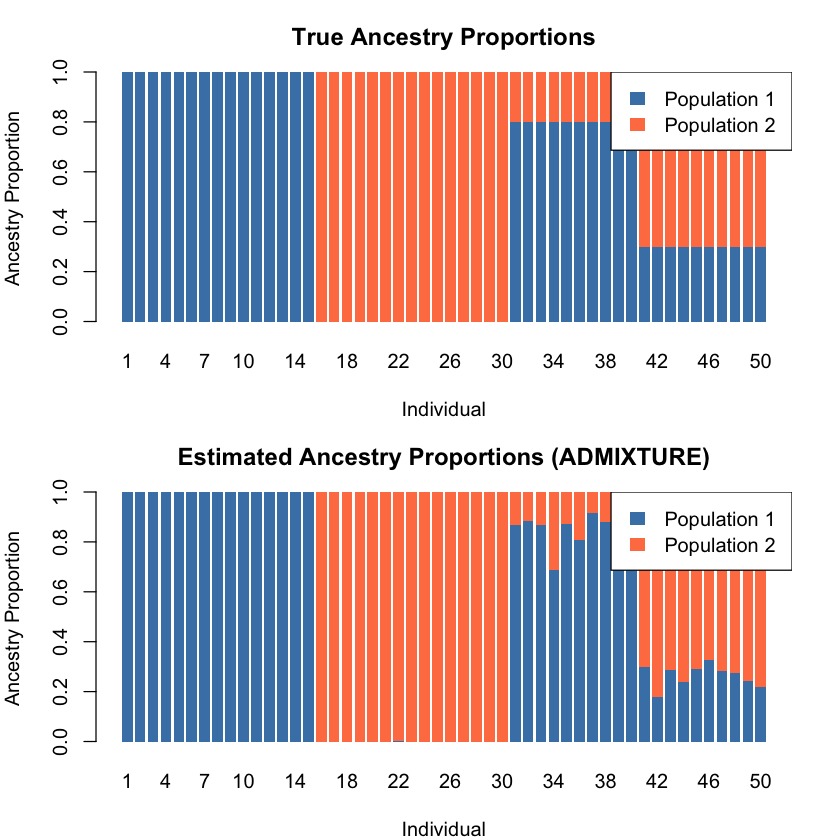

In [154]:
par(mfrow = c(2, 1), mar = c(4, 4, 3, 2))

# True ancestry
barplot(F_true, col = c("steelblue", "coral"), border = NA,
        main = "True Ancestry Proportions",
        xlab = "Individual", ylab = "Ancestry Proportion",
        names.arg = 1:I)
legend("topright", legend = c("Population 1", "Population 2"),
       fill = c("steelblue", "coral"), border = NA)

# Estimated ancestry
barplot(F_estimated, col = c("steelblue", "coral"), border = NA,
        main = "Estimated Ancestry Proportions (ADMIXTURE)",
        xlab = "Individual", ylab = "Ancestry Proportion",
        names.arg = 1:I)
legend("topright", legend = c("Population 1", "Population 2"),
       fill = c("steelblue", "coral"), border = NA)

## Example 2: Exploratory Factor Analysis in Gene Expression

Suppose you measure expression levels of five genes across 100 tissue samples. You notice that some genes tend to go up or down together—but why? Could it be because they're controlled by the same underlying biological pathway? In this example, we'll explore how factor analysis helps us uncover those hidden pathways. We'll start by letting the data show us what structure exists (exploratory analysis), and then we'll test a specific theory about which genes belong to which pathways -- showing how this detective work can reveal the invisible biological forces driving patterns in your data.

First, let's create toy data with a known structure where we have two latent biological pathways affecting gene expression.

### Generate Data

In [156]:
rm(list=ls())
library(psych)
library(lavaan)
library(ggplot2)
library(reshape2)

set.seed(29)

# ============================================================
# Create toy data with known structure
# ============================================================

n_samples <- 100   # 100 tissue samples
n_genes <- 5       # 5 genes total

# Two latent factors (biological pathways)
factor1 <- rnorm(n_samples)  # Inflammatory pathway activity
factor2 <- rnorm(n_samples)  # Metabolic pathway activity

# Create gene expression data
# Genes 1-2: belong to Factor 1 (Inflammatory)
# Genes 3-5: belong to Factor 2 (Metabolic)

expression <- matrix(0, nrow = n_samples, ncol = n_genes)

for (i in 1:n_samples) {
  # Genes 1-2: high loading on Factor 1
  expression[i, 1:2] <- 0.8 * factor1[i] + rnorm(2, 0, 0.3)
  
  # Genes 3-5: high loading on Factor 2
  expression[i, 3:5] <- 0.5 * factor2[i] + rnorm(3, 0, 0.3)
}

# Name the genes
colnames(expression) <- c(paste0("IL", 1:2),      # Inflammatory genes
                          paste0("METAB", 1:3))   # Metabolic genes

cat("Data dimensions:", nrow(expression), "samples x", ncol(expression), "genes\n")
cat("\nFirst few rows of expression data:\n")
round(head(expression), 2)

Data dimensions: 100 samples x 5 genes

First few rows of expression data:


IL1,IL2,METAB1,METAB2,METAB3
-1.27,-0.67,0.15,-0.25,-0.49
-1.05,-1.05,0.14,0.67,0.00
0.50,-0.05,-1.19,-0.86,-0.50
0.84,1.34,-0.83,-1.50,-0.02
-0.82,-0.89,0.44,0.82,0.36
1.54,1.61,1.08,0.77,0.95


### Correlation Between Genes

Before applying factor analysis, let's examine the correlation matrix between the gene expressions. Notice how genes within the same pathway are highly correlated.

=== Gene-Gene Correlation Matrix ===


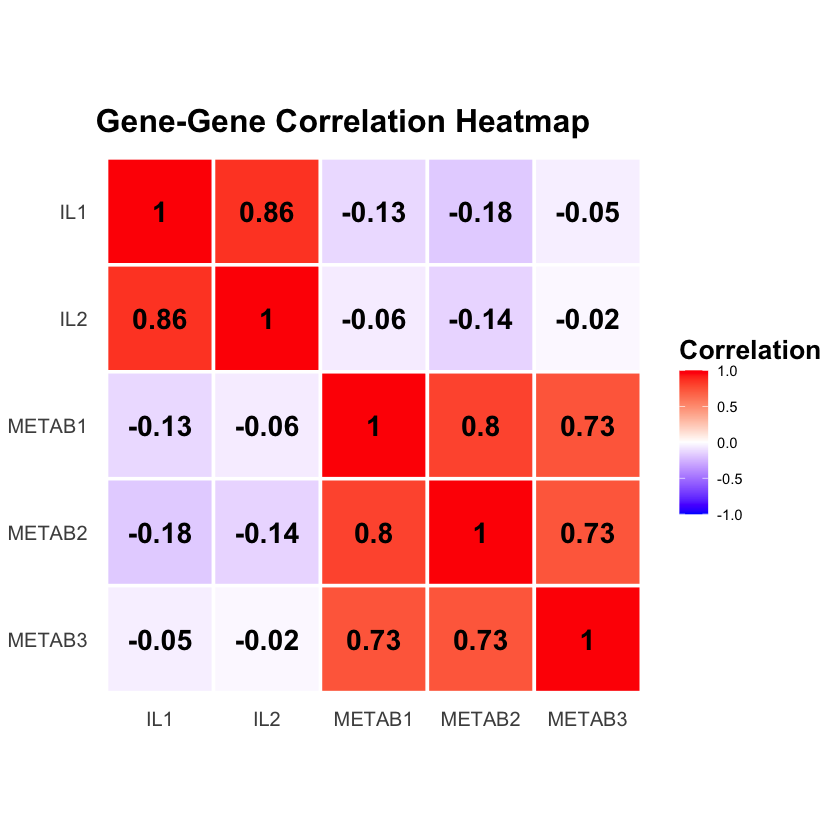

In [157]:
cat("=== Gene-Gene Correlation Matrix ===\n")
cor_matrix <- cor(expression)

# Convert correlation matrix to long format
cor_melted <- melt(cor_matrix)
colnames(cor_melted) <- c("Gene1", "Gene2", "Correlation")

# Reverse the factor order so it goes top to bottom and left to right
cor_melted$Gene1 <- factor(cor_melted$Gene1, levels = rev(colnames(cor_matrix)))
cor_melted$Gene2 <- factor(cor_melted$Gene2, levels = colnames(cor_matrix))

# Create ggplot heatmap
p_heatmap <- ggplot(cor_melted, aes(x = Gene2, y = Gene1, fill = Correlation)) +
  geom_tile(color = "white", linewidth = 1) +
  geom_text(aes(label = round(Correlation, 2)), 
            color = "black", size = 6, fontface = "bold") +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", 
                       midpoint = 0, limits = c(-1, 1)) +
  theme_minimal() +
  theme(
    title = element_text(size = 16, face = "bold"),
    axis.title = element_blank(),
    axis.text.x = element_text(size = 12),
    axis.text.y = element_text(size = 12),
    panel.grid = element_blank(),
    aspect.ratio = 1,
    panel.background = element_rect(fill = "transparent", color = NA),
    plot.background = element_rect(fill = "transparent", color = NA)
  ) +
  labs(title = "Gene-Gene Correlation Heatmap",
       fill = "Correlation")


print(p_heatmap)
ggsave("./cartoons/factor_analysis.png", plot = p_heatmap, width = 12, height = 6,  
       units = "in", dpi = 300, bg = "transparent")

### Conduct EFA

EFA is appropriate when we don't know the factor structure a priori. We let the data tell us which variables load on which factors.

We first use the proportion of variance explained criterion to decide how many factors to retain. This approach selects the minimum number of factors needed to explain a specified percentage of the total variance (e.g., 80%). This method is more interpretable than the Kaiser criterion because it directly relates to how much of the data's variability we're capturing, and it allows researchers to explicitly set a variance threshold based on their domain knowledge and practical requirements.

In [158]:
cat("\n=== EFA: Determining Number of Factors ===\n\n")

# Method 1: Eigenvalues and Variance Explained
ev <- eigen(cor_matrix)$values
cat("Eigenvalues:\n")
print(round(ev, 3))

# Calculate cumulative proportion of variance explained
variance_explained <- ev / sum(ev) * 100
cumulative_variance <- cumsum(variance_explained)

# Method: Determine factors based on cumulative variance threshold (e.g., 80%)
variance_threshold <- 80
n_factors_needed <- min(which(cumulative_variance >= variance_threshold))
cat(sprintf("\nNumber of factors needed to explain >= %d%% of variance: %d\n", 
            variance_threshold, n_factors_needed))



=== EFA: Determining Number of Factors ===

Eigenvalues:
[1] 2.589 1.786 0.286 0.201 0.138

Number of factors needed to explain >= 80% of variance: 2


Here we use the `fa` function in package `psych` to conduct factor analysis directly allowing for rotations of data points. Rotation makes the factors more interpretable by creating a simpler structure where each variable loads highly on few factors.

In [159]:
fa_efa <- fa(expression, nfactors = 2, rotate = "varimax", fm = "ml")

cat("\n=== EFA: ROTATED Factor Loadings (Varimax) ===\n")
fa_efa$loadings

# Examine communalities
cat("\n=== Communalities (variance explained by factors) ===\n")
print(round(fa_efa$communality, 3))


=== EFA: ROTATED Factor Loadings (Varimax) ===



Loadings:
       ML2    ML1   
IL1            0.895
IL2            0.957
METAB1  0.894       
METAB2  0.886 -0.133
METAB3  0.820       

                 ML2   ML1
SS loadings    2.261 1.737
Proportion Var 0.452 0.347
Cumulative Var 0.452 0.800


=== Communalities (variance explained by factors) ===
   IL1    IL2 METAB1 METAB2 METAB3 
 0.806  0.916  0.802  0.802  0.672 


#### Evaluate EFA Results

Factor scores represent the estimated values of the latent factors for each sample, and can be used in downstream analyses.


=== EFA Factor Scores (first 5 samples) ===
These represent pathway activity in each sample:



ML2,ML1
-0.287,-0.847
0.420,-1.090
-1.413,0.213
-1.300,1.528
0.836,-0.869



=== How Well Did EFA Recover the True Factors? ===
Factor 1 (Inflammatory) correlation: 0.955 
Factor 2 (Metabolic) correlation:    0.948 


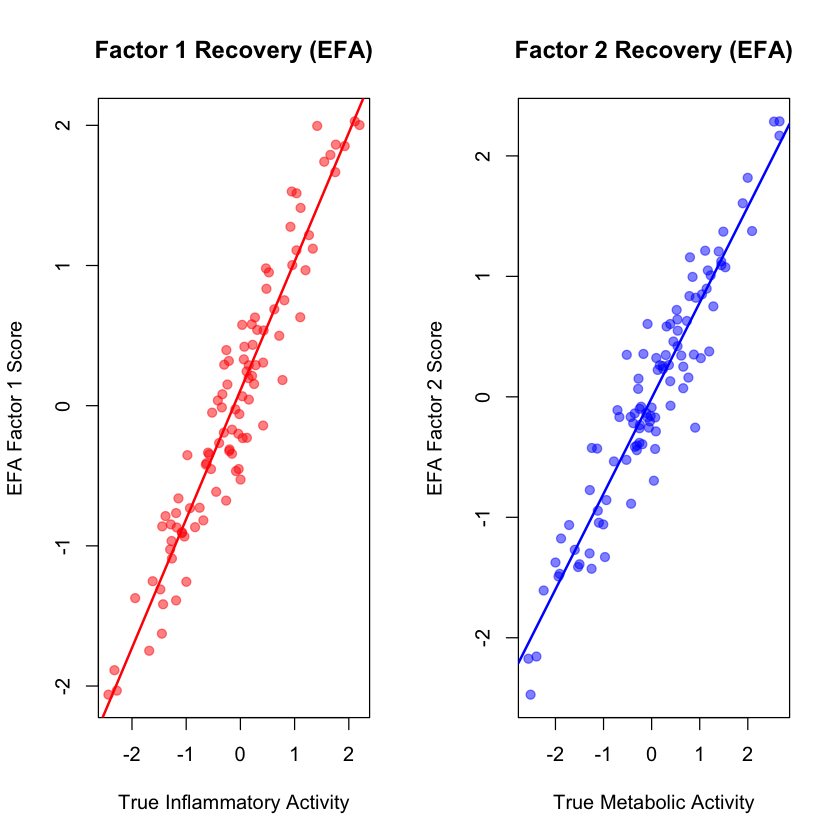

In [160]:
# Extract factor scores
factor_scores_efa <- fa_efa$scores

cat("\n=== EFA Factor Scores (first 5 samples) ===\n")
cat("These represent pathway activity in each sample:\n\n")
round(head(factor_scores_efa, 5), 3)

# How well did we recover the true factors?
cat("\n=== How Well Did EFA Recover the True Factors? ===\n")
cat("Factor 1 (Inflammatory) correlation:", round(abs(cor(factor1, factor_scores_efa[,2])), 3), "\n")
cat("Factor 2 (Metabolic) correlation:   ", round(abs(cor(factor2, factor_scores_efa[,1])), 3), "\n")

# Visualize the recovered factors
par(mfrow = c(1, 2))

plot(factor1, factor_scores_efa[,2],
     xlab = "True Inflammatory Activity",
     ylab = "EFA Factor 1 Score",
     main = "Factor 1 Recovery (EFA)",
     pch = 19, col = rgb(1, 0, 0, 0.5))
abline(lm(factor_scores_efa[,2] ~ factor1), col = "red", lwd = 2)

plot(factor2, factor_scores_efa[,1],
     xlab = "True Metabolic Activity",
     ylab = "EFA Factor 2 Score",
     main = "Factor 2 Recovery (EFA)",
     pch = 19, col = rgb(0, 0, 1, 0.5))
abline(lm(factor_scores_efa[,1] ~ factor2), col = "blue", lwd = 2)

# Extended Reading

- [Introduction to Probabilistic Topic Models](https://www.cs.columbia.edu/~blei/papers/Blei2012.pdf). DB Blei (2012). Communications of the ACM. 55 (4): 77-84.